__*Attribute Information:*__
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

__*class:*__
- class_0
- class_1
- class_2

This is a copy of UCI ML Wine recognition datasets. https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

__*Original Owners:*__

Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

__*Citation:*__

Lichman, M. (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

__*References*__

(1) S. Aeberhard, D. Coomans and O. de Vel, Comparison of Classifiers in High Dimensional Settings, Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Technometrics).

The data was used with many others for comparing various classifiers. The classes are separable, though only RDA has achieved 100% correct classification. (RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data)) (All results using the leave-one-out technique)

(2) S. Aeberhard, D. Coomans and O. de Vel, “THE CLASSIFICATION PERFORMANCE OF RDA” Tech. Rep. no. 92-01, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Journal of Chemometrics).

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Step 0. Data preparation

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape


(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


# Step 1. Preparing a neural network model

## Step 1.1. Model architecture

In [4]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()

        ## Fully conection, линейное преобразованиеб 2 входных нейрона
        ## Fully. conection представляет собой
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        ## Sigmoid as activation function
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      ## 3 значения НЕ вероятностей а SCORES
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      ## Here we'll get probabilities
      x = self.sm(x)
      return x

wine_net = WineNet(5)


## Step 1.2. Loss function

In [5]:
## Cross entropy loss function
loss = torch.nn.CrossEntropyLoss()


## Step 1.3. Optimizer

In [6]:
## We ned to pass model ad learning rate to Adam
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)


# Step 2. Training loop

In [7]:
np.random.permutation(5)


array([2, 0, 1, 4, 3])

In [8]:
##  Наверху расписание ходов батчей
batch_size = 10

for epoch in range(5000):
    ## Закидываем сюда
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad() ## Обнуляем градиенты


      batch_indexes = order[start_index:start_index+batch_size] ## Батч рассматриваем от стартового индекса
      ## с фиксированным offset = batch_size

      ## Попадают элементы по индексу
      x_batch = X_train[batch_indexes]

      ## Попадают ответы по индексу
      y_batch = y_train[batch_indexes]

      pred = wine_net.forward(x_batch)

      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()



    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())



tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5000)
tensor(0.4259)
tensor(0.4074)
tensor(0.5185)
tensor(0.5185)
tensor(0.4444)
tensor(0.4259)
tensor(0.5000)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7407)
tensor(0.6852)
tensor(0.6481)
tensor(0.6852)
tensor(0.6667)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7037)
tensor(0.7407)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


# Step 3. Visualization of dividing surfaces.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-9-4ffbf2cfa672>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  plt.scatter(X_train[indexes, 0],
<ipython-input-9-4ffbf2cfa672>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


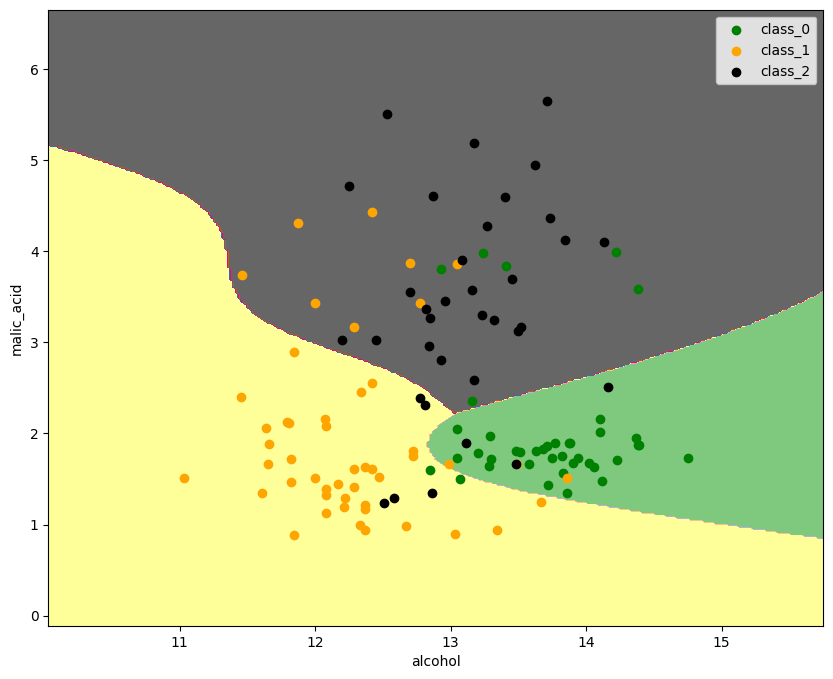

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c=color,
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()


# Step 4. Homework (60 points)

Let's practice with WineNet. Modify the architecture so that all 13 features are accepted as input and perform the following experiments:

1. Experiment with the number of neurons in the hidden layers. Try putting a very small number. Is there a threshold value for the number of hidden neurons at which learning becomes impossible?

2. Try passing different test_size values to the train_test_split function. At what value of test_size does the network predict worse than Base Rate*? And what is the Base Rate of the wine dataset?

3. Does the training time per epoch depend on the batch size? Explore this relationship.

As a report attach code and graphs that show all the necessary dependencies.

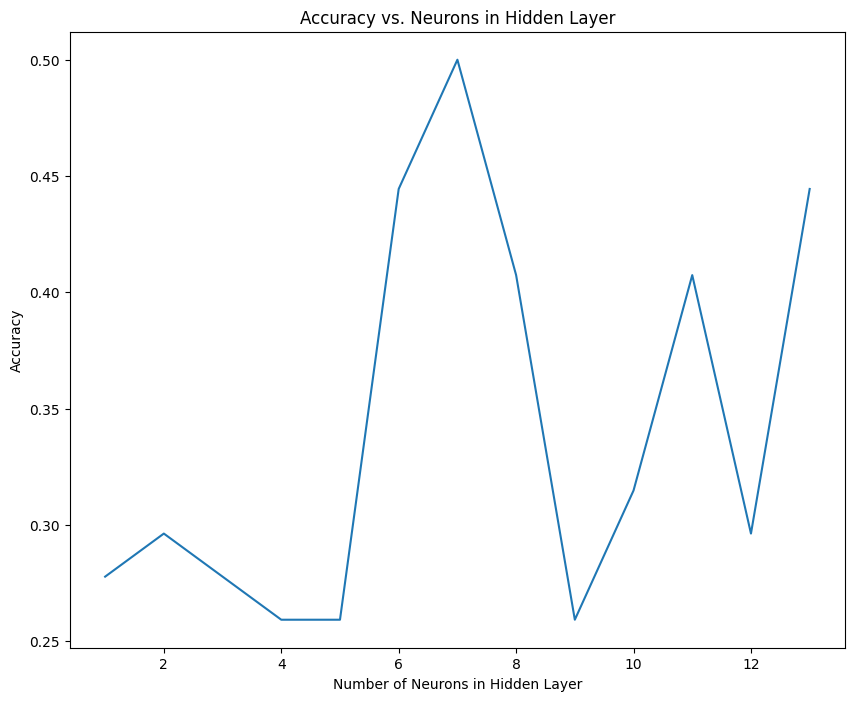

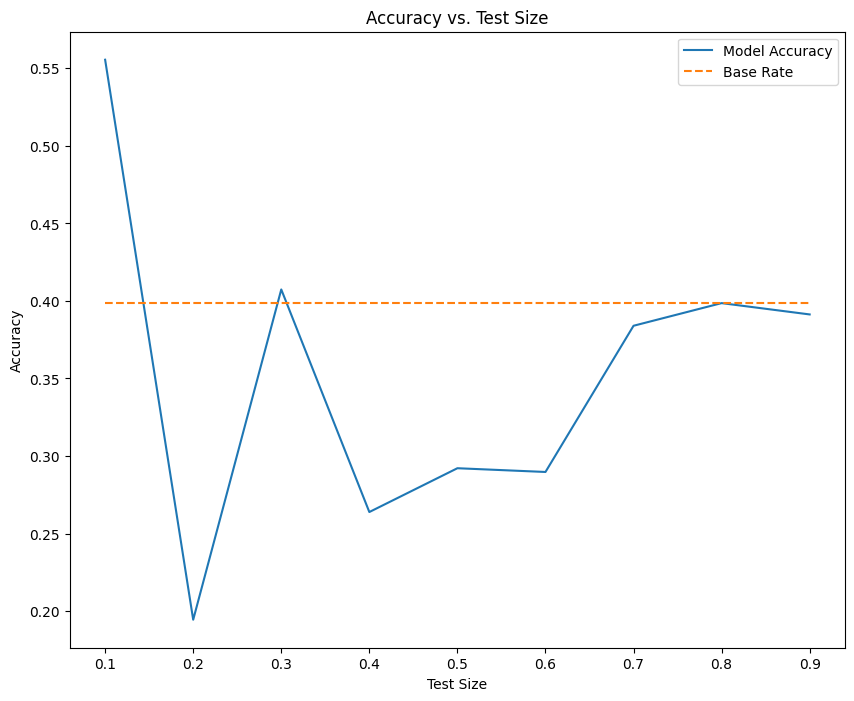

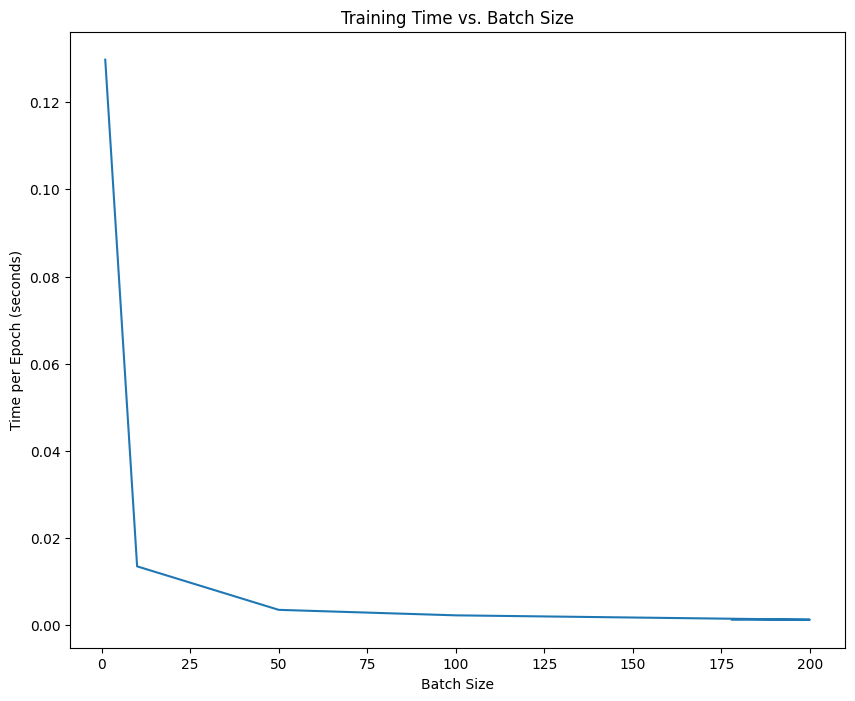

In [11]:
import torch
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

wine = load_wine()

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

def train_network(n_hidden_neurons, test_size, batch_size):
    X_train, X_test, y_train, y_test = train_test_split(
        wine.data,
        wine.target,
        test_size=test_size,
        shuffle=True)

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    wine_net = WineNet(n_hidden_neurons)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)

    start_time = time.time()

    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = wine_net.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    epoch_duration = time.time() - start_time

    test_preds = wine_net.forward(X_test)
    test_preds = test_preds.argmax(dim=1)
    accuracy = (test_preds == y_test).float().mean().item()

    return accuracy, epoch_duration

# Experiment 1: Neurons in Hidden Layers
neurons = list(range(1, 14))
accuracies = []
for n in neurons:
    acc, _ = train_network(n, 0.3, 10)
    accuracies.append(acc)

plt.figure()
plt.plot(neurons, accuracies)
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neurons in Hidden Layer')
plt.show()

# В какой-то момент модель перенасыщается и добавление новый
# нейронов не улучшает работу, а напротив даже можеь ухудшить

# Experiment 2: Different test_size values
test_sizes = np.linspace(0.1, 0.9, 9)
base_rate = max(np.bincount(wine.target)) / len(wine.target)
base_rates = [base_rate for _ in test_sizes]
test_accuracies = []
for ts in test_sizes:
    acc, _ = train_network(5, ts, 10)
    test_accuracies.append(acc)

plt.figure()
plt.plot(test_sizes, test_accuracies, label='Model Accuracy')
plt.plot(test_sizes, base_rates, label='Base Rate', linestyle='--')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Test Size')
plt.show()

# Чем больше test_size, тем. меньше train_size, так как мы разделяем данные на 2 части
# Запомнить: Выделять на test 30%

# Experiment 3: Batch Size impact on Training Time
batch_sizes = [1, 10, 50, 100, 200, len(wine.data)]
times = []
for bs in batch_sizes:
    _, epoch_time = train_network(5, 0.3, bs)
    times.append(epoch_time)

plt.figure()
plt.plot(batch_sizes, times)
plt.xlabel('Batch Size')
plt.ylabel('Time per Epoch (seconds)')
plt.title('Training Time vs. Batch Size')
plt.show()

# Чем меньше batch, тем чаще обновляются параметры => больше времени
